In [1]:
%matplotlib inline
import sympy as sp
import numpy as np
from time import sleep
from matplotlib.pyplot import *
from IPython.display import display, Markdown, Latex, clear_output

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
    """
    Return the matrix for the finite difference approximation of the prblem -u_{xx}(x) = f(x).
    
    Parameters
    ----------
    omega : list
        Interval of the problem. It is a list of two elements, where omega[0] is the lower bound of the interval and
        omega[1] is the upper bound of the interval.
    f : function
        Forcing function of the problem
    n : integer
        Number of discretization points
    bc : list
        Boundary conditions of the problem. It is a list of two elements containing the values of the boundary conditions
        
    Returns
    -------
    out : tuple
        Tuple containing the matrix and the known-term vector
    """
    
    A = np.zeros((n,n))
    b = np.zeros(n)
    h = (omega[1] - omega[0]) / (n - 1)
    discr_points = [omega[0] + i * h for i in range(n)]
    
    b[0], b[-1] = bc
     
    A = np.diag(np.ones(n-2),-2) + \
        np.diag(-16*np.ones(n-1),-1) + \
        np.diag(30*np.ones(n)) + \
        np.diag(-16*np.ones(n-1),1) + \
        np.diag(np.ones(n-2),2)
    
    f = np.vectorize(f)
    b[1:n-1] = f(discr_points[1:n-1])
    
    return A / (12*(h)**2), b

#### Precisation
To use the following methods, a symmetric matrix is required; hence, in the `finDif` function the boundary conditions were not added to the matrix ($A[i,j] = (e_i^j)^T,\ i = 0,n$ where $e_i^j$ is the j-th component of the i-th vector of the canonical basis) because that operation would have lead to a non-symmetric matrix. Without the specification of the boundary conditions, the solution found with the following methods is the one with boundary conditions of 0.

Call the function using:

In [3]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=400
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A, pivoting = True):
    """
    Return the LU factorization of the system matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the factorization.
        
    Returns
    -------
    out : tuple
        Tuple containing two elements: the lower-triangular matrix and the upper-trinagular matrix computed by the
        LU factorization.
    """
    
    n = len(A)
    L = np.zeros((n,n), dtype=float)
    U = A.copy().astype(float)
    P = np.eye(n)
    
    for k in range(n):
        if pivoting and U[k,k] == 0 and k < n-1:
            for w in range(k+1,n):
                if U[w,w] != 0:
                    U[[k,w]] = U[[w,k]]
                    L[[k,w]] = L[[w,k]]
                    P_temp = np.eye(n)
                    P_temp[[k,w]] = P_temp[[w,k]]
                    P = np.dot(P,P_temp)
    
        L[k+1:n,k] = U[k+1:n,k] / U[k,k]
        for i in range(k+1,n):
            for j in range(k,n):
                U[i,j] -= L[i,k] * U[k,j]
    np.fill_diagonal(L,1)
    
    if pivoting:
        return L, U, P
    
    return L, U

In [5]:
%time L, U, P = LU(A)
print("Is PA = LU ?",np.allclose(P.dot(A),L.dot(U)))

Wall time: 40.5 s
Is PA = LU ? True


In [6]:
def cholesky(A):
    """
    Return the Cholesky factorization of the system matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the factorization.
        The matrix must be symmetric and positive definite.
        
    Returns
    -------
    out : tuple
        Tuple containing two elements: the lower-triangular matrix and the upper-trinagular matrix computed by the
        Cholesky factorization (one is the transpose of the other).
    """
    
    assert np.allclose(A, A.T), "The matrix is not symmetric"
    
    n = len(A)
    L = np.zeros((n,n), dtype=float)
    
    L[0,0] = A[0,0]**.5
    for j in range(1,n):
        for i in range(0,j):
            L[i,j] = (A[j,i] - sum(L[:i,j]*L[:i,i])) / L[i,i]
    
        L[j,j] = (A[j,j] - sum(L[:j,j]**2))**.5

    return L.transpose(), L

In [7]:
%time HT, H = cholesky(A)
print("Is A = H^T * H ?",np.allclose(A,HT.dot(H)))

Wall time: 3.79 s
Is A = H^T * H ? True


Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [8]:
def L_solve(L,rhs):
    """
    Return the solution of a system of equations with lower-triangular matrix, using forward substitution algorithm.
    
    Parameters
    ----------
    L : numpy.array
        2-d numpy.array representing the upper triangular matrix.
    P : numpy.array
        2-d numpy.array representing the pivoting matrix
    rhs : numpy.array
        1-d numpy array representing the known-term vector of the system.
    
    Returns
    -------
    out : numpy.array
        The solution of the system.
    """
    x = np.zeros_like(rhs).astype(float)
    n = len(rhs)
    
    x[0] = rhs[0] / L[0,0]
    for i in range(1,n):
        x[i] = (rhs[i] - np.dot(L[i,:i],x[:i])) / L[i,i]
    
    return x

In [9]:
def U_solve(U,rhs):
    """
    Return the solution of a system of equations with upper-triangular matrix, using backward substitution algorithm.
    
    Parameters
    ----------
    L : numpy.array
        2-d numpy.array representing the upper triangular matrix.
    rhs : numpy.array
        1-d numpy array representing the known-term vector of the system.
    
    Returns
    -------
    out : numpy.array
        The solution of the system.
    """
    x = np.zeros_like(rhs).astype(float)
    n = len(rhs)
    
    x[-1] = rhs[-1] / U[-1,-1]
    for i in range(n-1,-1,-1):
        x[i] = (rhs[i] - np.dot(U[i,i+1:],x[i+1:])) / U[i,i]
    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

In [10]:
def solve_system(A, b, pivoting = True):
    """
    Return the solution of a system of equations using the LU factorization and then the forward and backward substitution
    algorithms.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix of the system.
    rhs : numpy.array
        1-d numpy array representing the known-term vector of the system.
    pivoting : boolean, optional
        True if the LU factorization is computed with pivoting
    
    Returns
    -------
    out : numpy.array
        The solution of the system.
    """
    
    if pivoting:    
        L, U, P = LU(A)
        b = P.dot(b)
        
    else:
        L, U = LU(A, pivoting = False)
        
    y = L_solve(L, b)
    x = U_solve(U, y)
    
    return x

Wall time: 38.1 s


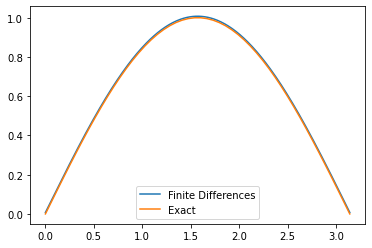

In [11]:
%time u = solve_system(A,b)
assert np.allclose(A.dot(u), b)
discr_points = np.linspace(omega[0],omega[1],n)
x = np.linspace(omega[0],omega[1])
plot(discr_points,u, label="Finite Differences")
plot(x,f(x), label="Exact")
_ = legend()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

0 %
20 %
40 %
60 %
80 %
100 %


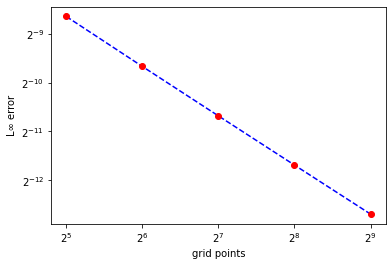

In [13]:
omega = [0,1]
f = lambda x : x*(1. - x)
bc = [0,0]
exact = lambda x : x**4/12 - x**3/6 + x/12

errors = []
perc = 0
print(perc, "%")

for n in (32,64,128,256,512):
    A,b = finDif(omega,f,n,bc)
    
    u = solve_system(A,b)
    discr_points = np.linspace(omega[0],omega[1],n)
    
    error = max(abs(exact(discr_points) - u))
    errors.append(error)

    perc += 20
    print(perc, "%")
    
ylabel("L∞ error")
xlabel("grid points")
scatter([2**i for i in range(5,10)],errors,color="r", zorder=2)
_ = loglog([2**i for i in range(5,10)],errors,"--b",base=2,zorder=1)

In [16]:
out = "| Grid points | L∞ error |\n|:---|:---|"
for i in range(5,10):
    out += "\n|" + str(2**i) + " | " + str(round(errors[i-5],8)) +  "|"
display(Markdown(out))

| Grid points | L∞ error |
|:---|:---|
|32 | 0.00249239|
|64 | 0.00122745|
|128 | 0.00060902|
|256 | 0.00030333|
|512 | 0.00015137|

Compute the inverse of the matrix A exploiting the derived LU factorization

In [18]:
def inverse(A):
    """
    Return the inverse of the matrix, using the LU factorization.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix to invert.
    
    Returns
    -------
    out : numpy.array
        2-d numpy.array representing the inverse of the matrix.
    """
    
    n = len(A)
    inv_cols = []
    L,U,P = LU(A)
    
    for i in range(n):
        e_i = np.array([[1 if k == i else 0] for k in range(n)])
        y = L_solve(L,np.dot(P,e_i))
        inv_cols.append(U_solve(U,y))
        
    return np.column_stack(inv_cols)

In [19]:
n=100
A, b = finDif(omega, f, n, bc)

%time A_inv = inverse(A)

print("Is A * A_inv = I ?",np.allclose(np.dot(A,A_inv),np.eye(n)))

Wall time: 945 ms
Is A * A_inv = I ? True


Exploit the derived LU factorizations to compute the condition number of the system's matrix $A$ using the original problem formulation.

In [20]:
def condNumb(A):
    """
    Return the condition number of the matrix, considering the l-infinity norm.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to calculate the condition number.
    
    Returns
    -------
    out : integer
        The condition number of the matrix.
    """
    
    A_inv = inverse(A)
    n = len(A)
    
    assert np.allclose(A.dot(A_inv),np.eye(n)), "Trubles when computing the inverse of the matrix."
    
    l_infty_norm     = max([sum(abs(A[i,:])) for i in range(n)])
    l_infty_norm_inv = max([sum(abs(A_inv[i,:])) for i in range(n)])
    
    return l_infty_norm * l_infty_norm_inv

%time cond_numb = round(condNumb(A),2)
print("Condition number of A: ",cond_numb)

Wall time: 991 ms
Condition number of A:  6778.96


Given the original $Au = b$ system, implement an algorithm to compute the eigenvalues and eigenvectors of the matrix $A$. Exploit the computed LU factorization

In [21]:
# Hypotesis: real eigenvalues
def gershgorin(A):
    """
    Return the set of gershgorin circles of the matrix; for every diagonal element, the radius of the corresponding circle
    is the minimum between the radius of the row and column circle.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to calculate the gershgoring circles.
    
    Returns
    -------
    out : list
        List of lists of two elements. The first element is the centre and the second is the radius of the circle.
    """
    
    n = len(A)
    circles = []
    
    # Row circles
    for i in range(n):
        radius = sum([abs(A[i,j]) if j != i else 0 for j in range(n)])
        circles.append([A[i,i],radius])
    
    # Columns circles
    for j in range(n):
        radius = sum([abs(A[i,j]) if i != j else 0 for i in range(n)])
        circles[j][1] = min(circles[j][1], radius)
          
    return circles

def eig_ranges(A):
    """
    Return a tuple of two elements:
    1: list containing the indexes of the connected components of the union of the Gershgorin circles.
    2: list of the Gershgorin circles.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix.
    
    Returns
    -------
    out : tuple
        tuple of two elements:
        1: List of lists. Every element represents a connected component of the union, and contains the indexes of the list of
        circles that belong to that component.
        2: List of the Gershgorin circles (center,radius)
    """
    circles = gershgorin(A)
    n = len(A)
    union = [[0]]
    
    circles = sorted(circles, key=lambda x:x[0]) # Sorted according to the center

    for i in range(1,n):
        prev_circ_right_boundary = circles[i-1][0] + circles[i-1][1]
        cur_circ_left_boundary = circles[i][0] - circles[i][1]
        if(prev_circ_right_boundary > cur_circ_left_boundary):
            for j in range(len(union)):
                if i-1 in union[j]:
                    union[j].append(i)
        else:
            union.append([i])
            
    return union, circles

def shifted_power_method(A,shift=0,epsilon = 1e-8,max_iter = 1e4):
    """
    Return the eigenvalue of the matrix A computed with the shifted power method, using a given shift.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix.
    shift : float, optional
        the shift of the power method; default is 0 (standard power method)
    epsilon : float, optional
        threshold of the distance between two eigenvalues computed in two subsequent iterations; default is 1e-8
    max_iter : integer, optional
        maximum number of iterations, deafult is 1e4
    
    Returns
    -------
    out : integer
        Eigenvalue computed with the shifted power method.
    """
    
    n = len(A)
    A_shift = A - shift*np.eye(n)
    A_shift_inverse = inverse(A_shift)
        
    assert np.allclose(A_shift.dot(A_shift_inverse),np.eye(n)), "Trubles when computing the inverse of the matrix."
    
    x = np.ones(n)
    y = x / np.linalg.norm(x)
    err = 1
    n_iter = 0
    eig_prec = 0
    eig_cur = 0
    
    while n_iter < max_iter and err > epsilon * eig_cur:
    
        x = A_shift_inverse.dot(y)
        y = x / np.linalg.norm(x)
        eig_cur = 1./(np.dot(y.dot(A_shift_inverse),y))
        
        err = abs(eig_cur - eig_prec)
        eig_prec = eig_cur
        n_iter += 1
        
    return eig_cur + shift

def eigenvalues(A, epsilon = 1e-8, max_iter = 1e4):
    """
    Return all real eigenvalues of the matrix A.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to compute the eigenvalues.
    epsilon : float, optional
        threshold of the distance between two eigenvalues computed in two subsequent iterations; default is 1e-8
    max_iter : integer, optional
        maximum number of iterations for every eigenvalue to compute, deafult is 1e4
    
    Returns
    -------
    out : integer
        Eigenvalue computed with the shifted power method.
    """
    
    ranges, circles = eig_ranges(A)
    eigenvalues = []
    
    for interval in ranges:        
        for i in range(len(interval)):
            center = circles[interval[i]][0]
            shift = np.random.normal(loc = center)
            eigenvalues.append(shifted_power_method(A, shift, epsilon, max_iter))
    
    return eigenvalues

In [22]:
# Small test
ex = np.array([[10,-1,0,1],\
               [0.2,8,0.2,0.2],\
               [1,1,2,1],\
               [-1,-1,-1,-11]])

res = eigenvalues(ex)
exact = np.sort(np.linalg.eig(ex)[0])
assert np.allclose(res,exact)
print("Eigenvalues of\n", ex, ":\n", res)

Eigenvalues of
 [[ 10.   -1.    0.    1. ]
 [  0.2   8.    0.2   0.2]
 [  1.    1.    2.    1. ]
 [ -1.   -1.   -1.  -11. ]] :
 [-10.8691016591071, 1.89948876031966, 8.147824458769408, 9.821788443500086]


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

In [23]:
def conjugate_gradient(A, b, P, nmax=1e6, eps=1e-10):
    """
    Return the result of a preconditioned conjugant gradient method.
    
    Parameters
    ----------
    A : numpy.array
        2-d numpy.array representing the matrix for which to, approximately, solve the linear system.
    b : numpy.array
        array of known terms of the system (rhs vector).
    P : numpy.array
        2-d numpy.array representing the preconditioner of the method.
    nmax : integer, optional
        maximum number of iterations of the method; default is len(A).
    eps : float, optional
        threshold of the error between the residuals of two subsequent iterations; default is 1e-10.
    
    Returns
    -------
    out : numpy.array
        The approximate solution of the linear system.
    """
    
    A = np.array(A, dtype="float")
    b = np.array(b, dtype="float")
    L_pr, U_pr, P_pr = LU(P)
    
    
    n = len(A)
    x = np.ones(n)
    r = b - A.dot(x)
    
    y = L_solve(L_pr,np.dot(P_pr,r))
    z = U_solve(U_pr,y)
    
    p = z
    n_iter = 0
    
    while n_iter < nmax and np.linalg.norm(r) > eps:
        alpha = np.dot(p,r) / np.dot(A.dot(p),p)
        x = x + alpha * p
        r = r  - alpha*A.dot(p)
 
        y = L_solve(L_pr,np.dot(P_pr,r))
        z = U_solve(U_pr,y)
        
        beta = np.dot(z,A.dot(p)) / np.dot(p,A.dot(p))
        p =  z - beta*p
        
        n_iter += 1
    
    return x

Wall time: 9.02 s


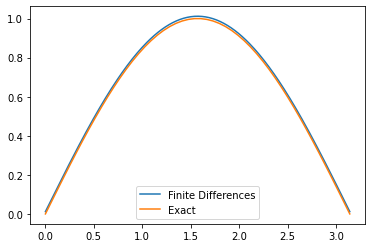

In [24]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=250
bc = [0,0]
A, b = finDif(omega, f, n, bc)

%time u = conjugate_gradient(A,b, np.diag(A)*np.eye(n))

discr_points = np.linspace(omega[0],omega[1],n)
x = np.linspace(omega[0],omega[1])
plot(discr_points,u, label="Finite Differences")
plot(x,f(x), label="Exact")
_ = legend()

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [25]:
def newton(f, x0, eps = 1e-10, n_max = 1000):
    """
    Return the zero of the function using the Newton's method.
    
    Parameters
    ----------
    f : function
        Function for which to compute the zero.
    x0 : float
        Starting point of the method.
    eps : float, optional
        Threshold of the difference between two iterations.
    n_max : integer
        Maximum number of iterations to use in the method.
    
    Returns
    -------
    out : float
        The approximate root of the function near the starting point.
    """
    
    w = sp.symbols("w")
    f_prime_sympy = sp.diff(f(w))
    f_prime = sp.lambdify(w,f_prime_sympy)
    
    assert abs(f_prime(x0)) > 1e-16, "Negative derivative in x0." # check that the derivative is not 0
    err = abs(f(x0))
    it = 0
    x = x0 # current x
    while it < n_max and err > eps:
        q = f_prime(x)
        x_new = x - f(x) / q
        err = abs(f(x_new))
        it += 1
        x = x_new
    
    return x_new

In [26]:
def backward_euler(omega, ic, f, num_discr_points):
    """
    Return the numerical approximation of the given Cauchy problem.
    
    Parameters
    ----------
    omega : list
        List of two elements; the first is the lower bound of the interval of the problem,
        the second is the upper bound of the interval.
    ic : float
        Initial condition of the problem.
    f : function
        Forcing function of two variables of the problem; the first variable is t, the second is u. 
    num_discr_points : integer
        Number of discretization points to use in the approximation.
    
    Returns
    -------
    out : numpy.array
        The approximate solution of the Cauchy problem; the len(out) = discr_points.
    """
    
    u = np.zeros(num_discr_points)
    t = np.linspace(omega[0],omega[1],num_discr_points)
    h = (omega[1] - omega[0]) / num_discr_points
    
    u[0] = ic
    
    for i in range(1,num_discr_points):
        _phi = lambda u_n : u[i - 1] + h * f(t[i], u_n)
        _F = lambda u_n : u_n - _phi(u_n)
        u[i] = newton(_F,u[i-1])

    
    return t, u

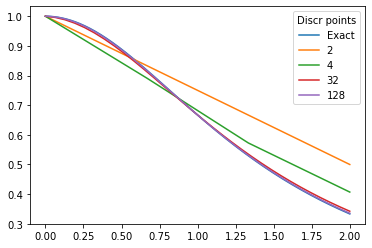

In [27]:
def f(t,y):
    return -t * (y**2)
ic = 1
omega = [0,2]

exact = lambda t : 2 / (t**2 + 2)

t = np.linspace(omega[0],omega[1],1000)
plot(t,exact(t),label="Exact")

for i in (2,4,32,128):
    t,u = backward_euler(omega,ic,f,i)
    plot(t,u,label=str(i))
_ = legend(title = "Discr points")

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u_t -u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


#### Proposed solution
Both the time and space intervals will be discretized.<br>
- Space interval $\Omega$ will be discretized in a sequence of points $x_i = i * h_x$, $i = 0,...,N_x$ where $h_x = \frac{\pi}{N_x-1}$ and $N_x$ is the number of discretization points in the space interval.
- Time interval $[0,T]$ will be discretized in a sequence of points $t_i = i * h_t$, $i = 0,...,N_t$ where $h_t = \frac{T}{N_t-1}$ and $N_t$ is the number of discretization points in the time interval.
The problem is reformulated as:

$$
\begin{cases}
u_t = u_{xx} + a(t)f(x) \\
u(0,t) = u(\pi,t) = 0 &, \forall \ t \in [0,T]\\
u(x,0) = u_o(x) &, \forall \ x \in [0,\pi]
\end{cases}$$
<br>
Where $u_o(x)$ is the solution of the problem $-u_{xx} = f(x)$ with the same boundary conditions.
<br>
The second pure partial derivative in respect to $x$ is approximated with the finite differences scheme of the original problem, hence

$$u_t(t,x_i) = \frac{-u(t,x_{i-2}) + 16u(t,x_{i-1})-30u(t,x_i) + 16u(t,x_{i+1}) - u(t,x_{i+2})}{12h_x^2} + a(t)f(x_i)$$

This equation can be rewritten as follows

$$\boldsymbol{u_t}(t) = A\boldsymbol{u}(t) + a(t)\boldsymbol{f}$$

Where $\boldsymbol{u_t}(t) = (u_t(t,x_0),u_t(t,x_1),...,u_t(t,x_{N_x}))^T$, $\boldsymbol{u}(t) = (u(t,x_0),u(t,x_1),...,u(t,x_{N_x}))^T$, $\boldsymbol{f}(t) = (f(x_0),f(x_1),...,f(x_{N_x}))^T$ and $A = -A_o$ where $A_o$ is the matrix of the original problem.
<br>
It is thus obtained a system of ordinary differential equations which can be solved using the forward Euler method:

$$\boldsymbol{u_t}(t_j) = \frac{\boldsymbol{u}(t_{j+1}) - \boldsymbol{u}(t_j)}{h_t} \ , \ j = 0,...,N_t - 1$$

$$\Rightarrow \frac{\boldsymbol{u}_{j+1} - \boldsymbol{u}_j}{h_t} = \boldsymbol{u_t}(t_j) =  A\boldsymbol{u}_j + \boldsymbol{a}_j\boldsymbol{f}$$

$$\Rightarrow \boldsymbol{u}_{j+1} = \boldsymbol{u}_j +  h_tA\boldsymbol{u}_j + h_t\boldsymbol{a}_j\boldsymbol{f} \ , \ j = 0,...,N_t - 1$$

Where $\boldsymbol{u}_j = u(t_j)$ and $I$ is the identity matrix.

In [28]:
def _converge_fe(h,A):
    rho = max(abs(np.linalg.eig(A)[0]))
    return h < 2 / rho
    
    
def _forward_euler_linear(omega, ic, A, b, num_discr_points, check = True):
    """
    Return the approximate solution of a linear system of differential equations using the forward Euler method.
    
    Parameters
    ----------
    omega : list
        List of two elements; the first is the lower bound of the interval of the problem,
        the second is the upper bound of the interval.
    ic : numpy.array
        Initial condition of the problem; must be of the same length of the linear system.
    A : numpy.ndarray
        Matrix of the linear system of ODE. 
    b : numpy.array
        Vector of known term of the system of ODE.
    num_discr_points : integer
        Number of discretization points to be used in the method.
    check : boolean
        If True, the function checks if the method converge.
    
    Returns
    -------
    out : numpy.ndarray
        Matrix representing the solution of the system. The i-th row represents the solution at step i.
    """
    
    u = np.zeros((num_discr_points,len(ic)))
    u[0] = ic
    h = (omega[1] - omega[0]) / (num_discr_points - 1)
    
    if check:
        assert _converge_fe(h,A), "The method is not stable."
    
    for i in range(num_discr_points - 1):
        u[i + 1] = u[i] + h * (np.dot(A,u[i]) + b[i])
        
    return u

def solve_PDE(omega, boundary_cond, initial_cond, a, f, num_discr_points):
    """
    Return the approximate solution of the PDE.
    
    Parameters
    ----------
    omega : list
        List of lists of two elements; the first list is the the time interval, the second is the space interval.
    boundary_cond : list
        List containing the boundary condition of the problem.
    initial_cond : function
        Function representing the initial condition of the problem. 
    a : function
        Function "a" in the problem.
    f : function
        Function "f" in the problem.
    num_discr_points : list
        List of integers; the first integer is the number of discretization points to be used in the time interval,
        the second is for the space interval.
    
    Returns
    -------
    out : tuple
        Tuple containing: the array of time steps, the array of space steps, 
        the solution in form of a matrix of the PDE.
    """
    
    omega_time  = omega[0]
    omega_space = omega[1]
    num_discr_time  = num_discr_points[0]
    num_discr_space = num_discr_points[1]

    t = np.linspace(omega_time[0],omega_time[1],num_discr_time)
    x = np.linspace(omega_space[0],omega_space[1],num_discr_space)
    ic = np.vectorize(initial_cond)(x)
    _f = np.vectorize(f)(x)
    
    A, _ =  finDif(omega_space, f, num_discr_space, boundary_cond)
    A = -A
    A[0,:] = np.zeros(num_discr_space)
    A[-1,:] = np.zeros(num_discr_space)
    A[0,0] = A[-1,-1] = 1
    b = np.zeros((num_discr_time, num_discr_space))
    for i in range(num_discr_time):
        b[i] = a(t[i]) * _f
    
    u = _forward_euler_linear(omega_time, ic, A, b, num_discr_time)
    
    return t,x,u

In [29]:
def plot_PDE_sol(t,x,sol,wait=0.1):
    """
    Plot the solution of the PDE in the space domain, as time flows. 
    The values at x = 1, x = pi/2, x = pi are highlighted.    
    
    Parameters
    ----------
    t : numpy.array
        Array of time steps.
    x : numpy.array
        Array of space steps.
    sol : numpy.ndarray
        Matrix representing the approximate solution of the problem. 
    wait : float, optional
        For how many seconds to wait between one plot and the other; default is 0.1.
    """
    
    _min = sol.min()
    _max = sol.max()
    
    fig = figure()
    ax = fig.add_subplot(1, 1, 1)
    step = len(t) // 200
    for i in range(0,len(t),step):
        ax.cla()
        ax.title.set_text("Time: " + str(round(t[i],3)) + " s")
    
        one_index = int(len(x) // np.pi)
        pi_half_index = len(x) // 2
    
        ax.vlines([x[one_index],x[pi_half_index],np.pi],_min,_max,colors="#ffa500",linestyles="dashed",zorder=1)
        ax.text(np.pi,_min-0.2,'π')
        ax.text(np.pi/2,_min-0.2,'π/2')
        ax.plot(x, sol[i], zorder=2)
        ax.scatter([x[one_index],x[pi_half_index],np.pi],sol[i,[one_index,pi_half_index,len(x)-1]], color="r",zorder=3)

        ax.set_xlim(0, np.pi + 0.1)
        ax.set_ylim(_min, _max)
        display(fig)
    
        clear_output(wait = True)
        sleep(wait)

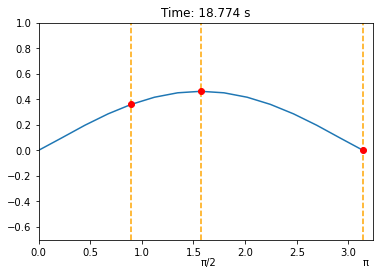

In [30]:
init_cond = lambda x : np.sin(x)
omega = [[0,6*np.pi],[0,np.pi]]
boundary_cond = [0,0]
a = lambda t : np.cos(t)
num_discr_points = [1000,15]

t,x,sol = solve_PDE(omega,boundary_cond,init_cond,a,init_cond,num_discr_points)

plot_PDE_sol(t,x,sol,0.001)

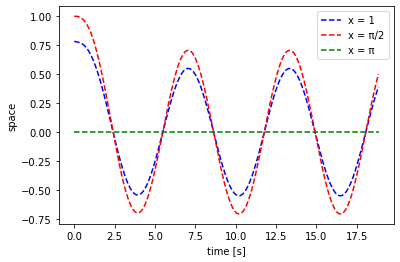

In [31]:
one_index = int(len(x) // np.pi)
pi_half_index = len(x) // 2

plot(t,sol[:,one_index],"--b",label="x = 1")
plot(t,sol[:,pi_half_index],"--r",label="x = π/2")
plot(t,sol[:,len(x)-1],"--g",label="x = π")
xlabel("time [s]")
ylabel("space")
_ = legend()